# Model Comparison


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, f1_score)
import joblib


In [2]:
# Load environment variables from .env file
load_dotenv()

# Get directory paths from environment variables
NOTEBOOKS_DIR_PATH = os.getenv('NOTEBOOKS_DIR_PATH')
DATASETS_DIR_PATH = os.getenv('DATASETS_DIR_PATH')
RAPORTS_DIR_PATH = os.getenv('RAPORTS_DIR_PATH')
MODELS_DIR_PATH = os.getenv('MODELS_DIR_PATH')

# Define file paths
processed_data_path = os.path.join('..', DATASETS_DIR_PATH, 'processed_data.csv')
models_dir = os.path.join('..', MODELS_DIR_PATH)

In [3]:
# Load the processed data
df = pd.read_csv(processed_data_path)

# Prepare data for evaluation
X = df.drop('passed', axis=1)
y = df['passed']

# We will use the same train_test_split as before (with random_state=0 and test_size=0.3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Load Trained Models

Załadujmy wcześniej wytrenowane i zapisane modele: Logistic Regression, KNN oraz SVM.


In [4]:
# Paths to the saved models
logistic_model_path = os.path.join(models_dir, 'logistic_regression_model.joblib')
knn_model_path = os.path.join(models_dir, 'knn_model.joblib')
svm_model_path = os.path.join(models_dir, 'svm_model.joblib')

# Load models
logistic_model = joblib.load(logistic_model_path)
knn_model = joblib.load(knn_model_path)
svm_model = joblib.load(svm_model_path)


## Evaluate Each Model

Obliczymy metryki takie jak Accuracy, F1-score, ROC-AUC oraz wyświetlimy confusion matrix dla każdego modelu.


In [5]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'model': model_name,
        'accuracy': acc,
        'f1': f1,
        'auc': auc,
        'cm': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluate each model
logistic_results = evaluate_model(logistic_model, X_test, y_test, 'Logistic Regression')
print("-----------------------------------------------------")
knn_results = evaluate_model(knn_model, X_test, y_test, 'KNN')
print("-----------------------------------------------------")
svm_results = evaluate_model(svm_model, X_test, y_test, 'SVM')


Model: Logistic Regression
Accuracy: 0.5966
F1 Score: 0.7391
ROC AUC: 0.6930
Confusion Matrix:
[[ 3 47]
 [ 1 68]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.06      0.11        50
         1.0       0.59      0.99      0.74        69

    accuracy                           0.60       119
   macro avg       0.67      0.52      0.43       119
weighted avg       0.66      0.60      0.48       119

-----------------------------------------------------
Model: KNN
Accuracy: 0.5630
F1 Score: 0.7174
ROC AUC: 0.6639
Confusion Matrix:
[[ 1 49]
 [ 3 66]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.25      0.02      0.04        50
         1.0       0.57      0.96      0.72        69

    accuracy                           0.56       119
   macro avg       0.41      0.49      0.38       119
weighted avg       0.44      0.56      0.43       119

----------------------------------

## Compare Models

Teraz porównamy metryki wszystkich trzech modeli.


In [6]:
results_df = pd.DataFrame([
    [logistic_results['model'], logistic_results['accuracy'], logistic_results['f1'], logistic_results['auc']],
    [knn_results['model'], knn_results['accuracy'], knn_results['f1'], knn_results['auc']],
    [svm_results['model'], svm_results['accuracy'], svm_results['f1'], svm_results['auc']]
],
columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC'])

results_df


,Model,Accuracy,F1 Score,ROC AUC
0,Logistic Regression,0.596639,0.739130,0.693043
1,KNN,0.563025,0.717391,0.663913
2,SVM,0.596639,0.739130,0.724928


## ROC Curves Comparison

Porównajmy krzywe ROC wszystkich trzech modeli na jednym wykresie.


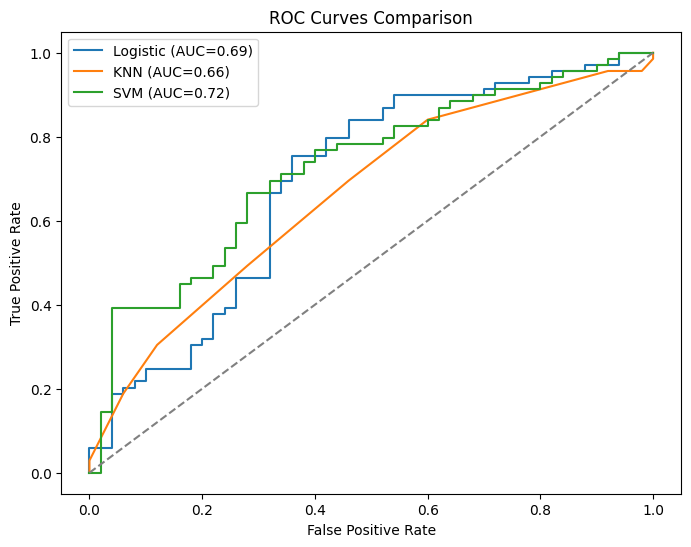

In [7]:
plt.figure(figsize=(8,6))

# Logistic ROC
fpr_l, tpr_l, _ = roc_curve(y_test, logistic_results['y_pred_proba'])
plt.plot(fpr_l, tpr_l, label=f"Logistic (AUC={logistic_results['auc']:.2f})")

# KNN ROC
fpr_k, tpr_k, _ = roc_curve(y_test, knn_results['y_pred_proba'])
plt.plot(fpr_k, tpr_k, label=f"KNN (AUC={knn_results['auc']:.2f})")

# SVM ROC
fpr_s, tpr_s, _ = roc_curve(y_test, svm_results['y_pred_proba'])
plt.plot(fpr_s, tpr_s, label=f"SVM (AUC={svm_results['auc']:.2f})")

plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

## Best Model Selection

Na podstawie metryk takich jak Accuracy, F1 Score oraz ROC AUC wybierzemy najlepszy model.


In [8]:
# Let's say we prioritize F1 Score or Accuracy. You can adjust the metric according to your need.
best_model = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]
print("Best Model based on F1 Score:")
print(best_model)


Best Model based on F1 Score:
Model       Logistic Regression
Accuracy               0.596639
F1 Score                0.73913
ROC AUC                0.693043
Name: 0, dtype: object
